# Create the Atlas

Import the registered nii files and create the atlas for WM, GM, and CSF

In [1]:
from os import listdir
from os.path import isdir, join
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

/home/okozyn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def show_slice(img, slice_no):
    """
        Inputs: img (nibabel): image name
                slice_no (np slice): np.s_[:, 30, :]
        """
    data = img.get_fdata()
    plt.figure()
    plt.imshow(data[slice_no].T, cmap='gray')
    plt.show()

In [3]:
# Set path to labels folder and import transformed labels into python
data_dir = "./training-set/registration-results/transformed_labels/"
onlydirs = [f for f in listdir(data_dir) if isdir(join(data_dir, f))]

# Key the labels already in the files
CSF_label = 1
GM_label = 3
WM_label = 2


CSF_im = None

# Import each label and create a label maps
for dir in onlydirs:
    labels = join(data_dir, dir,'result.nii.gz')
    labels_img = nib.load(labels)
    labels_data = labels_img.get_data()
    
    if CSF_im is None:
        # Array definitions to store the label counts
        CSF_im = np.zeros_like(labels_data)
        WM_im = np.zeros_like(labels_data)
        GM_im = np.zeros_like(labels_data)
        temp_CSF_im = np.zeros_like(labels_data)
        temp_WM_im = np.zeros_like(labels_data)
        temp_GM_im = np.zeros_like(labels_data)
    
    #Assign CSF to 1
    temp_CSF_im[labels_data == CSF_label] = 1
    #Assign GM to 2
    temp_GM_im[labels_data == GM_label] = 1
    #Assign WM to 1
    temp_WM_im[labels_data == WM_label] = 1
    
    CSF_im = CSF_im + temp_CSF_im
    GM_im = GM_im + temp_GM_im
    WM_im = WM_im + temp_WM_im
    
# For each array, count the occurences and find the probability
tot_im = CSF_im + GM_im + WM_im
print(tot_im.shape)
CSF_probs = np.divide(CSF_im, tot_im)
CSF_probs = np.nan_to_num(CSF_probs)
GM_probs = np.divide(GM_im, tot_im)
GM_probs = np.nan_to_num(GM_probs)
WM_probs = np.divide(WM_im, tot_im)
WM_probs = np.nan_to_num(WM_probs)

(256, 287, 256)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


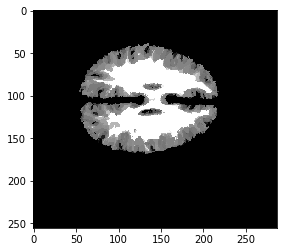

In [4]:
plt.imshow(WM_probs[:,:,150], cmap = "gray")
plt.show()

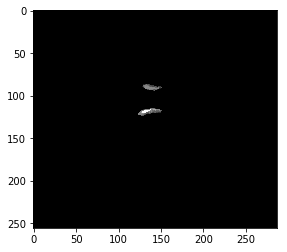

In [5]:
plt.imshow(CSF_probs[:,:,150], cmap = "gray")
plt.show()

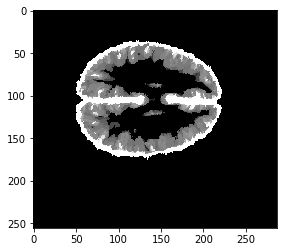

In [6]:
plt.imshow(GM_probs[:,:,150], cmap = "gray")
plt.show()

In [25]:
# Save 3 atlases
GM_nii = nib.Nifti1Image(GM_probs, labels_img.affine, labels_img.header)
nib.save(GM_nii, './our_atlas/GM_probs.nii')
WM_nii = nib.Nifti1Image(WM_probs, labels_img.affine, labels_img.header)
nib.save(WM_nii, './our_atlas/WM_probs.nii')
CSF_nii = nib.Nifti1Image(CSF_probs, labels_img.affine, labels_img.header)
nib.save(CSF_nii, './our_atlas/CSF_probs.nii')

## Split Template Atlas in Three

In [7]:
from nibabel.funcs import four_to_three

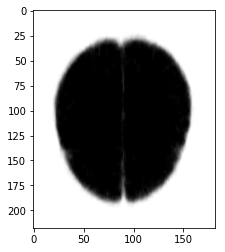

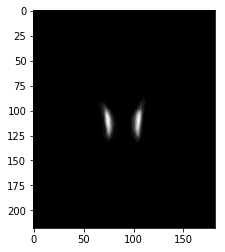

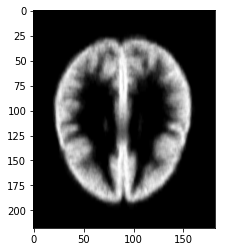

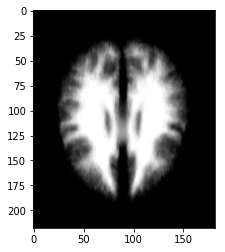

In [18]:
mni_atlas_folder = './MNITemplateAtlas/'
mni_atlas_path = 'atlas.nii.gz'

mni_atlas = nib.load(join(mni_atlas_folder, mni_atlas_path))
# 1st - Mask, 2nd - CSF, 3rd - GM, 4th - WM
ext = '.nii.gz'
names = ['Mask', 'CSF_probs', 'GM_probs', 'WM_probs']

imgs = four_to_three(mni_atlas)

for index, img in enumerate(imgs):
    show_slice(img, np.s_[:, :, 100])
    if index != 0:
        out_name = names[index] + ext
        nib.save(img, join(mni_atlas_folder, out_name))
    

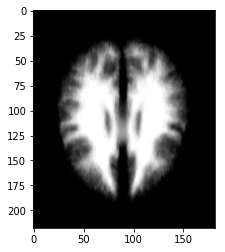

In [19]:
test_out_atlas = './MNITemplateAtlas/WM_probs.nii.gz'

test_wm = nib.load(test_out_atlas)
show_slice(test_wm, np.s_[:, :, 100])

## Build Tissue Model (Histograms)

In [1]:
atlas_path = "./our_atlas"

max_intens = 999

# Key the labels already in the files
CSF_label = 1
GM_label = 3
WM_label = 2

In [2]:
# Normalize array from 0 to max_intens
def normalize(target_array, max_intens=255):
    target_array -= target_array.min()
    normalized_array = max_intens * np.divide(target_array, target_array.max())
    return normalized_array.astype(int)

In [22]:
# Load all data for histogram
template_data = nib.load(join(atlas_path, 'mean_im.nii')).get_data()
template_data = normalize(template_data, max_intens)
template_data_flat = template_data.flatten()

CSF_atlas = nib.load(join(atlas_path, 'CSF_probs.nii')).get_data()
GM_atlas = nib.load(join(atlas_path, 'GM_probs.nii')).get_data()
WM_atlas = nib.load(join(atlas_path, 'WM_probs.nii')).get_data()

CSF_mask = CSF_label * np.nan_to_num((CSF_atlas > WM_atlas) * (CSF_atlas > GM_atlas))
GM_mask = GM_label * np.nan_to_num((GM_atlas > CSF_atlas) * (GM_atlas > WM_atlas))
WM_mask = WM_label * np.nan_to_num((WM_atlas > CSF_atlas) * (WM_atlas > GM_atlas))

CSF_intensities = template_data_flat[CSF_mask.flatten() != 0]
GM_intensities = template_data_flat[GM_mask.flatten() != 0]
WM_intensities = template_data_flat[WM_mask.flatten() != 0]

In [23]:
# get histograms
bins = tuple(range(0, max_intens+2))
CSF_hist, _ = np.histogram(CSF_intensities, bins, density=True)
GM_hist, _ = np.histogram(GM_intensities, bins, density=True)
WM_hist, _ = np.histogram(WM_intensities, bins, density=True)
bins = bins[:-1]

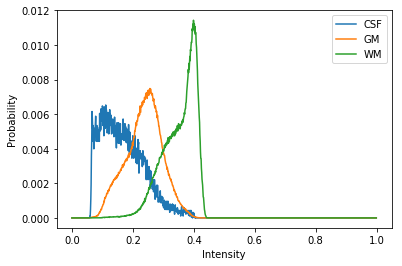

In [39]:
# plot histograms
plt.plot(bins, CSF_hist, bins, GM_hist, bins, WM_hist)
#plt.title("CSF Histogram")
plt.xlabel("Intensity")
plt.ylabel("Probability")
plt.legend(["CSF", "GM", "WM"])
plt.show()